In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from LSTM_model import get_LSTM_Classifier
from dataloader import LSSTSourceDataSet, ts_length
from loss import WHXE_Loss
from taxonomy import get_taxonomy_tree

from argparse import ArgumentParser
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras

## Load and balance the tensors:

In [7]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

X_ts = load("processed/x_ts.pkl")
X_static = load("processed/x_static.pkl")
Y = load("processed/y.pkl")
lengths = load("processed/lengths.pkl")
astrophysical_classes = load("processed/a_labels.pkl")
elasticc_classes = load("processed/e_label.pkl")

In [10]:
# Balance the data set in some way
max_class_count = 10000

X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
lengths_balanced = []
astrophysical_classes_balanced = []
elasticc_classes_balanced = []

for c in np.unique(astrophysical_classes):
    
    print(c)
    idx = np.where(np.array(astrophysical_classes) == c)[0]
    
    if len(idx) > max_class_count:
        idx = idx[:max_class_count]
 
    X_ts_balanced += [X_ts[i] for i in idx]
    X_static_balanced += [X_static[i][2] for i in idx]
    Y_balanced += [Y[i] for i in idx]
    astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]
    elasticc_classes_balanced += [elasticc_classes[i] for i in idx]

print(np.unique(astrophysical_classes_balanced, return_counts=True))
all_classes = list(set(astrophysical_classes))
all_classes.sort()

def get_labels(astrophysical_class):
    
    l = np.zeros(19) 
    l[all_classes.index(astrophysical_class)] = 1
    return l
    
print(all_classes)

AGN
CART
Cepheid
Delta Scuti
Dwarf Novae
EB
ILOT
KN
M-dwarf Flare
PISN
RR Lyrae
SLSN
SNI91bg
SNII
SNIa
SNIax
SNIb/c
TDE
uLens
(array(['AGN', 'CART', 'Cepheid', 'Delta Scuti', 'Dwarf Novae', 'EB',
       'ILOT', 'KN', 'M-dwarf Flare', 'PISN', 'RR Lyrae', 'SLSN',
       'SNI91bg', 'SNII', 'SNIa', 'SNIax', 'SNIb/c', 'TDE', 'uLens'],
      dtype='<U13'), array([10000,  3517,  5901,  8849,  3439, 10000,  3197,  1896,   796,
       10000,  6014, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
        7537]))
['AGN', 'CART', 'Cepheid', 'Delta Scuti', 'Dwarf Novae', 'EB', 'ILOT', 'KN', 'M-dwarf Flare', 'PISN', 'RR Lyrae', 'SLSN', 'SNI91bg', 'SNII', 'SNIa', 'SNIax', 'SNIb/c', 'TDE', 'uLens']


In [11]:
# Pad for TF masking layer
for ind in range(len(X_ts_balanced)):
    X_ts_balanced[ind] = np.pad(X_ts_balanced[ind], ((0, ts_length - len(X_ts_balanced[ind])), (0, 0)))

In [12]:
# Split into train and validation
X_ts_train, X_ts_val, X_static_train, X_static_val, Y_train, Y_val, astrophysical_classes_train, astrophysical_classes_val, elasticc_classes_train, elasticc_classes_val = train_test_split(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, elasticc_classes_balanced, shuffle=True, random_state = 40, test_size = 0.1)

# Do some processing for tensorflow
X_ts_train = np.squeeze(np.array(X_ts_train))
X_ts_val = np.squeeze(np.array(X_ts_val))

X_static_train = np.squeeze(np.array(X_static_train))
X_static_val = np.squeeze(np.array(X_static_val))

Y_train = np.squeeze(np.array(Y_train))
Y_val = np.squeeze(np.array(Y_val))

## Attempting non hierarchichal, multi label classification.

In [13]:
# Loss and optimizer
tree = get_taxonomy_tree()
loss_object = WHXE_Loss(tree, astrophysical_classes_train) 
criterion = loss_object.compute_loss

In [17]:
# Inputs for model
ts_dim = 5
static_dim = 1
output_dim = 26
latent_size = 64

num_epochs = 5
batch_size = 1024

In [18]:
model = get_LSTM_Classifier(ts_dim, static_dim, output_dim, latent_size, criterion)

In [19]:

early_stopping = EarlyStopping(
                          patience=5,
                          min_delta=0.001,                               
                          monitor="val_loss",
                          restore_best_weights=True
                          )


history = model.fit(x = [X_ts_train, X_static_train],  y = Y_train, validation_data=([X_ts_val, X_static_val], Y_val), epochs=num_epochs, batch_size = batch_size, callbacks=[early_stopping])


model.save(f"models/RedshiftLatent_{latent_size}.keras")

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 560s 4s/step - accuracy: 0.0000e+00 - loss: 0.3041 - val_accuracy: 0.0000e+00 - val_loss: 0.2617
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 576s 5s/step - accuracy: 0.0000e+00 - loss: 0.2521 - val_accuracy: 0.0000e+00 - val_loss: 0.2389
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 563s 5s/step - accuracy: 0.0000e+00 - loss: 0.2225 - val_accuracy: 0.0000e+00 - val_loss: 0.2076
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 558s 4s/step - accuracy: 0.0000e+00 - loss: 0.2012 - val_accuracy: 0.0000e+00 - val_loss: 0.1914
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 557s 4s/step - accuracy: 0.0000e+00 - loss: 0.1807 - val_accuracy: 0.0000e+00 - val_loss: 0.1687


In [40]:
model1 = keras.models.load_model(f"models/RedshiftLatent_{latent_size}.keras", compile=False)

In [41]:
Y_val_pred = model.predict([X_ts_val, X_static_val])
Y_val_pred = np.argmax(Y_val_pred[:, -19:], axis=1)
Y_val_true = np.argmax(Y_val[:, -19:], axis=1)

442/442 ━━━━━━━━━━━━━━━━━━━━ 60s 136ms/step


In [42]:
Y_val_pred.shape, Y_val_true.shape

((14115,), (14115,))

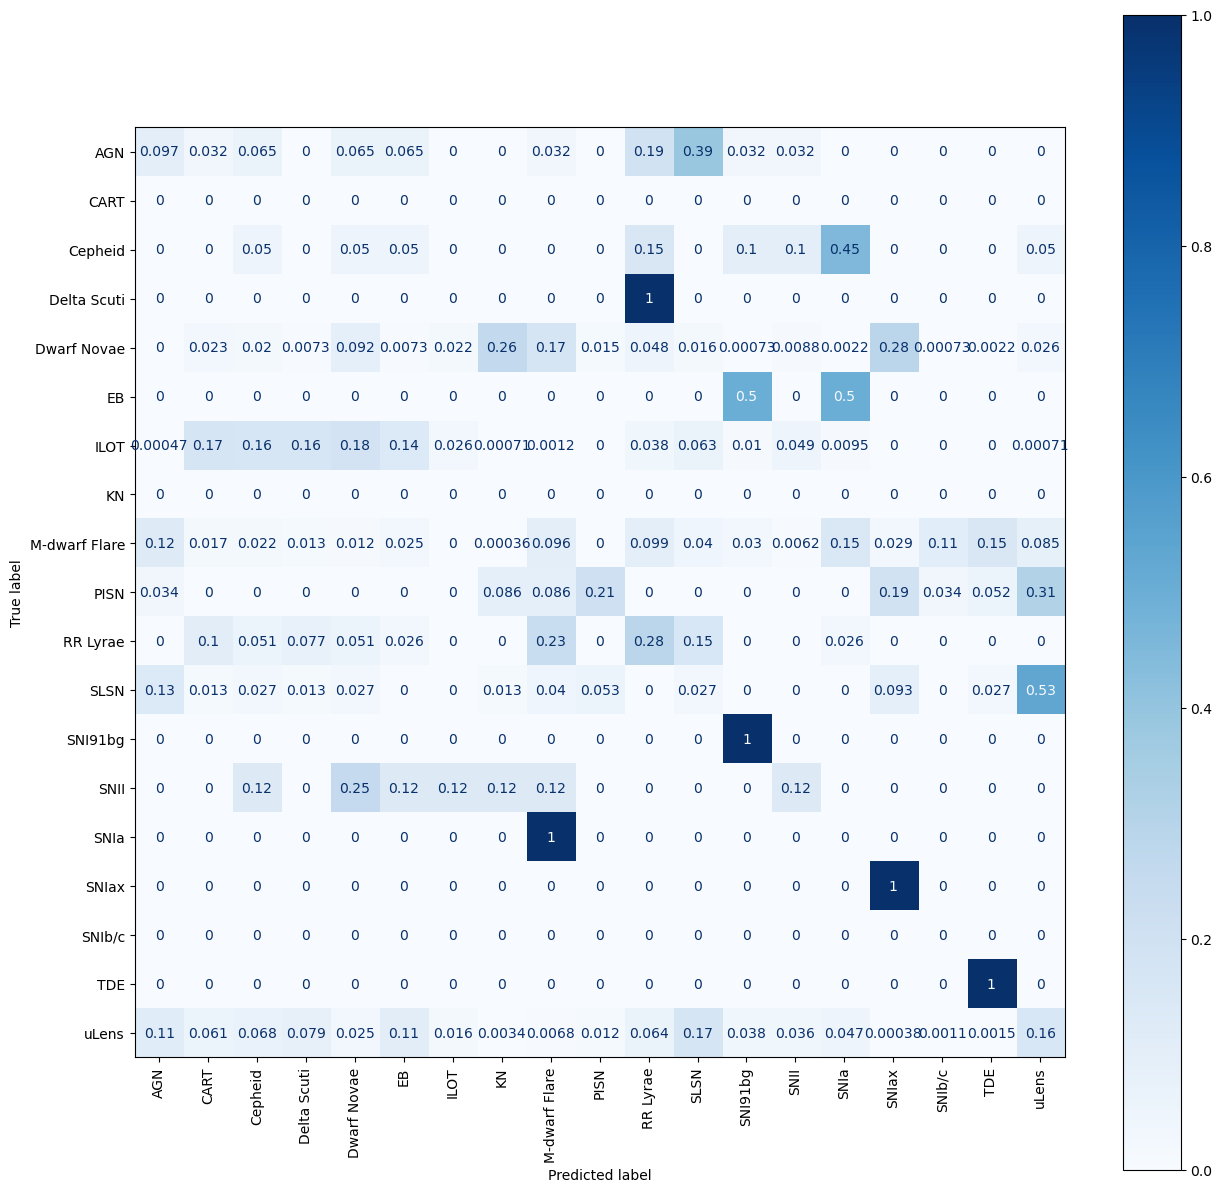

In [43]:
cm = confusion_matrix(Y_val_pred, Y_val_true, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
disp.plot(cmap=plt.cm.Blues)

fig = disp.figure_
plt.xticks(rotation=90)


fig.set_figwidth(15)
fig.set_figheight(15)
plt.savefig('baseline_leaf.png')

In [44]:
Y_val_pred = model.predict([X_ts_val, X_static_val])
Y_val_pred = np.argmax(Y_val_pred[:, 1:3], axis=1)
Y_val_true = np.argmax(Y_val[:, 1:3], axis=1)

442/442 ━━━━━━━━━━━━━━━━━━━━ 51s 115ms/step


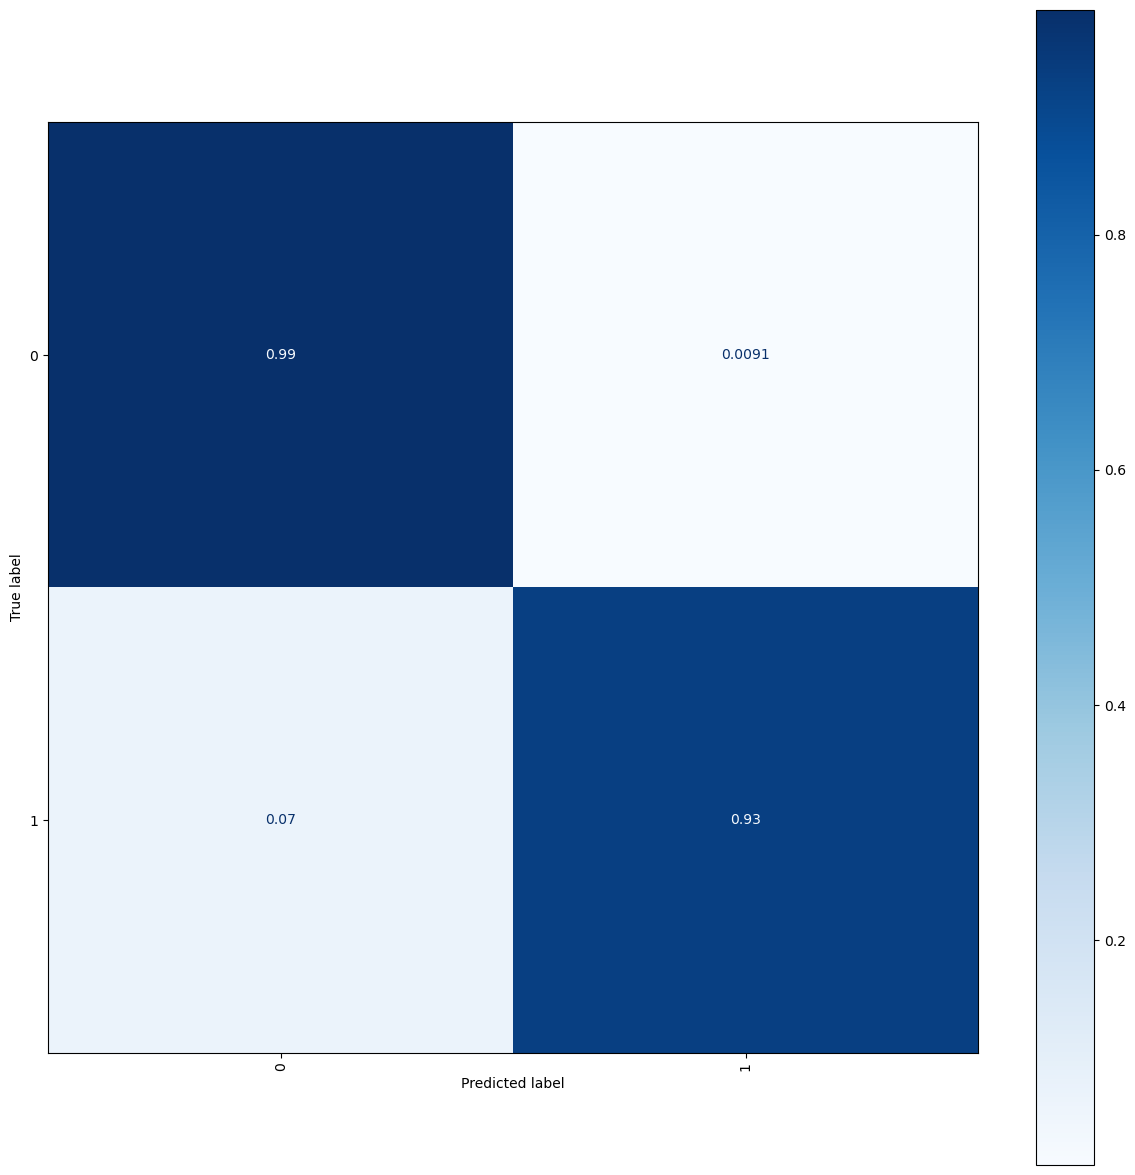

In [45]:
cm = confusion_matrix(Y_val_pred, Y_val_true, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

fig = disp.figure_
plt.xticks(rotation=90)


fig.set_figwidth(15)
fig.set_figheight(15)
plt.savefig('baseline_root.png')